# Estimation of FRET efficiency for emission from WS2 and absorption by diamond NV- center.

Based on Medintz & Hildebrandt, 2014, pages 23-31.

FRET efficiency, $E$, is
$$
E = \frac{R_0^6}{R_0^6 + r_{DA}^6}
$$
where
$r_{DA}$ is the distance between donor and acceptor
and 
$R_0$ is the Förster distance.
This is also expressed as
$$
E = \frac{k_T}{k_T + 1/\tau_D}
$$
where
$k_T$ is the rate of energy transfer
and $t_D$ is the lifetime of the donor excited state in the absence of acceptor.
The formula for $k_T$ is
$$
k_T = \frac{1}{\tau_D} \left( \frac{R_0^6}{r_{DA}^6} \right)
$$

The Förster distance $R_0^6$ is a key quantity to compute,
and is given as
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
where $\kappa^2$ is the orientation factor,
$\Phi_D$ is the quantum yield of the donor fluorescence in the absence of acceptor,
$J$ is the overlap integral,
$\pi = 3.14159...$,
$n$ is the index of refraction of the medium,
and $N_A$ is the Avogadro number $6.0221415 \times 10^{23}$ per mol.

The overlap integral $J$, is computed differently depending on whether the spectra are given in terms of wavelength, wave number, or frequency. For wavelength,
$$
J^\lambda = J = \int f_D(\lambda) \epsilon_A(\lambda) \lambda^4 \mathrm{d} \lambda
$$
where $f_D(\lambda)$ is the fluorescence spectrum of the donor,
$\epsilon_A(\lambda)$ is the molar extinction coefficient (a.k.a. molar absorptivity) of the acceptor (usually in units of $\mathrm{M}^{-1} \mathrm{cm}^{-1}$), and $\lambda$ is the wavelength (usually in nm).

In [47]:
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

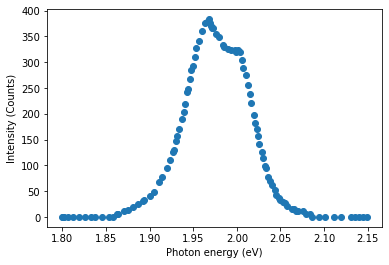

In [3]:
WS2_eV, WS2_intensity, _, _, _, _ = np.loadtxt("WS2_emission.txt", unpack=True)
plt.clf()
plt.scatter(WS2_eV, WS2_intensity)
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (Counts)");

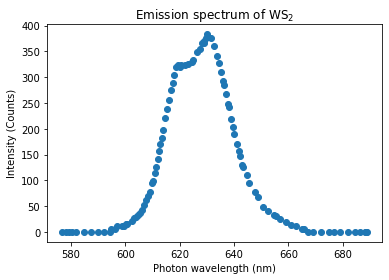

In [15]:
hc = 1239.8 # eV nm
WS2_nm = hc/WS2_eV
plt.clf()
plt.scatter(WS2_nm, WS2_intensity)
plt.title("Emission spectrum of $\mathrm{WS_2}$")
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (Counts)");

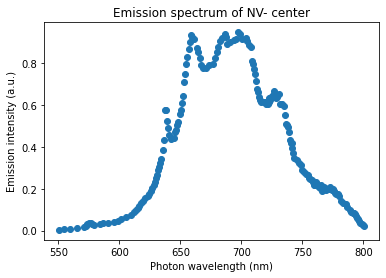

In [17]:
nv_center_emission_nm, nv_center_emission_intensity, _, _, _, _ = np.loadtxt("NV_center_emission.txt", unpack=True)
plt.clf()
plt.scatter(nv_center_emission_nm, nv_center_emission_intensity)
plt.title("Emission spectrum of NV- center")
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Emission intensity (a.u.)");

Since this is the emission spectrum of the diamond NV- center, not the absorption / excitation spectrum, we will need to flip the spectrum around the zero phonon line at 637 nm to approximate the absorption spectrum.

In [18]:
nv_center_absorption_nm = 637 - (nv_center_emission_nm - 637)

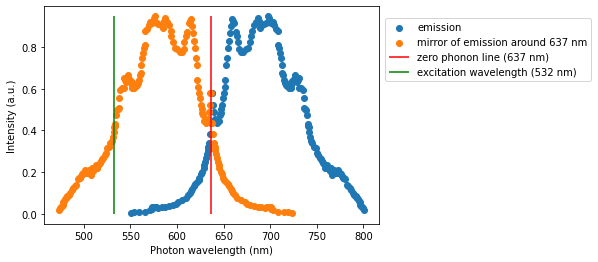

In [60]:
plt.clf()
plt.scatter(nv_center_emission_nm, nv_center_emission_intensity, label="emission")
plt.scatter(nv_center_absorption_nm, nv_center_emission_intensity, label="mirror of emission around 637 nm")
plt.vlines(x=637, ymin=0, ymax=max(nv_center_emission_intensity), color="red", label="zero phonon line (637 nm)")
plt.vlines(x=532, ymin=0, ymax=max(nv_center_emission_intensity), color="green", label="excitation wavelength (532 nm)")
plt.legend(loc="center right", bbox_to_anchor=(1.65,0.8))
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (a.u.)");

Compare the image from the Wikipedia page for NV centers:

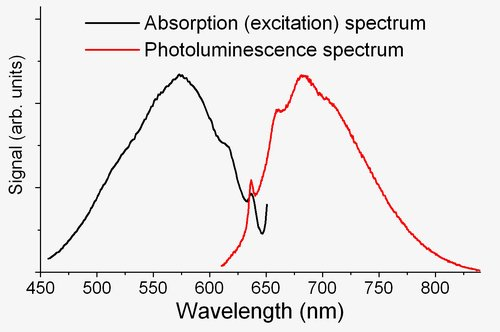

In [49]:
IPython.display.Image(filename="NVple.JPG")

The NV- spectrum has a one-photon absorption cross section specified at 532 nm, so we should normalize the spectrum so that it has the correct absorption at that value.

In [50]:
i_closest_to_532nm = np.abs(532 - nv_center_absorption_nm).argmin()
intensity_closest_to_532nm = nv_center_emission_intensity[i_closest_to_532nm]
nv_center_absorption_intensity = nv_center_emission_intensity/intensity_closest_to_532nm

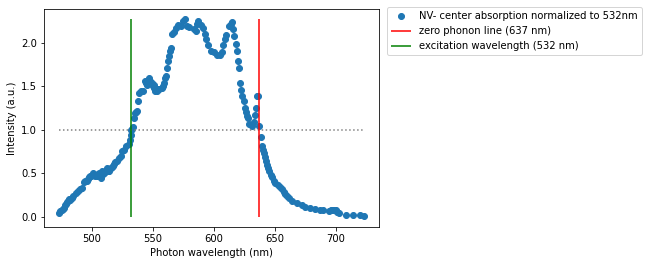

In [59]:
plt.clf()
plt.hlines(y=1.0, xmin=min(nv_center_absorption_nm), xmax=max(nv_center_absorption_nm), color="gray", linestyles="dotted")
plt.scatter(nv_center_absorption_nm, nv_center_absorption_intensity, label="NV- center absorption normalized to 532nm")
plt.vlines(x=637, ymin=0, ymax=max(nv_center_absorption_intensity), color="red", label="zero phonon line (637 nm)")
plt.vlines(x=532, ymin=0, ymax=max(nv_center_absorption_intensity), color="green", label="excitation wavelength (532 nm)")
plt.legend(loc="center right", bbox_to_anchor=(1.8,0.9))
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Intensity (a.u.)");

Now let's see what the $\mathrm{WS_2}$ emission looks like overlaid on the NV- center absorption spectrum.

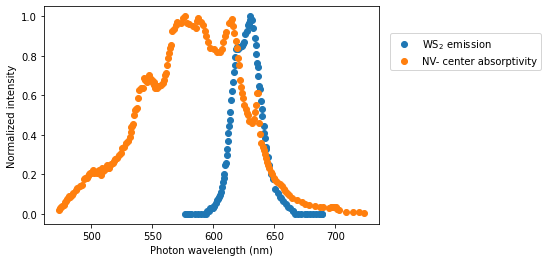

In [65]:
plt.clf()
plt.scatter(WS2_nm, WS2_intensity/WS2_intensity.max(), label="$\mathrm{WS}_2$ emission")
plt.scatter(nv_center_absorption_nm, nv_center_absorption_intensity/nv_center_absorption_intensity.max(), label="NV- center absorptivity")
plt.xlabel("Photon wavelength (nm)")
plt.legend(loc="best", bbox_to_anchor=(1.5,0.9));
plt.ylabel("Normalized intensity");

In [64]:
def overlap_from_acceptor_OLI(
        donor_lambda,
        donor_fluorescence,
        acceptor_lambda,
        acceptor_extinction,
        molar_attenuation_coefficient):
    # In this method, we run over acceptor lambdas.
    assert len(donor_lambda) == len(donor_fluorescence)
    assert len(acceptor_lambda) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    donor_norm = donor_fluorescence/donor_fluorescence.max()
    # Peak-normalize acceptor.
    acceptor_norm = acceptor_extinction/acceptor_extinction.max()
    # Only go over the overlapping lambda range.
    lambda_min = max(donor_lambda.min(),acceptor_lambda.min())
    lambda_max = min(donor_lambda.max(),acceptor_lambda.max())
    wavelengths = []
    J_raw = []
    for i, wavelength_nm in enumerate(acceptor_lambda):
        if wavelength_nm < lambda_min:
            continue
        elif wavelength_nm > lambda_max:
            continue
        wavelengths.append(wavelength_nm)
        # eps_A has units of 1/(M cm)
        eps_A = acceptor_norm[i]*molar_attenuation_coefficient
        # OLI is 10^14 M^-1 cm^-1 nm^4
        # Find index of closest corresponding wavelength in donor_lambda.
        # TODO: issue a warning if the acceptor data is too sparse.
        j = np.abs(donor_lambda - wavelength_nm).argmin()
        f_D = donor_norm[j]
        J_val = 1e-14 * f_D * eps_A * (wavelength_nm**4)
        J_raw.append(J_val)
    lambda_J = np.array(wavelengths)
    J = np.array(J_raw) / donor_norm.sum()
    return lambda_J, J

In [ ]:
# TODO: fix this
molar_attenuation_coefficient = None #  M^-1 cm^-1

lambda_J_acceptor, J_acceptor = overlap_from_acceptor_OLI(
    WS2_nm,
    WS2_intensity,
    nv_center_absorption_nm,
    nv_center_absorption_intensity,
    molar_attenuation_coefficient)

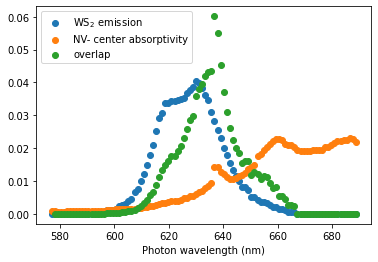

In [8]:
plt.clf()
plt.scatter(lambda_range, WS2_intensity_new/WS2_intensity_new.sum(), label="$\mathrm{WS}_2$ emission")
plt.scatter(lambda_range, nv_center_intensity_new/nv_center_intensity_new.sum(), label="NV- center absorptivity")
plt.scatter(lambda_range[1:], J_lambda/J_lambda.sum(), label="overlap")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

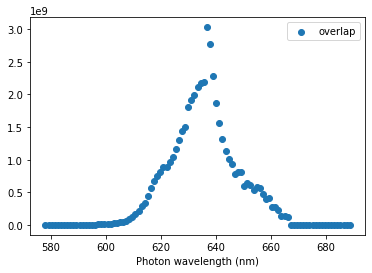

In [9]:
plt.clf()
plt.scatter(lambda_range[1:], J_lambda, label="overlap")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

In [10]:
J_sum = J_lambda.sum()
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, n_diamond, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.34, r_DA)
print(E_total)
E_total = FRET_efficiency(kappa2, Phi_D, J_sum, 1.6, r_DA)
print(E_total)

6.7551962552541494e-21
7.150318365526233e-20
3.517747328423862e-20
